<a href="https://colab.research.google.com/github/CharlyWheels/Carlos_Rueda_TFM/blob/colab/Labepc_CNN_padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import json
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/labdata.csv', engine='python')
df.shape

(1173, 38)

In [116]:
print(df.columns)

Index(['id', 'reference', 'epc', 'score', 'count', 'maxRssiValue',
       'minRssiValue', 'maxTimeStamp', 'minTimeStamp', 'rssiDiff', 'seenDiff',
       'antenna1', 'antenna2', 'antenna3', 'antenna4', 'ts_percent0',
       'ts_percent1', 'ts_percent2', 'ts_percent3', 'ts_percent4',
       'ts_percent5', 'ts_percent6', 'ts_percent7', 'ts_percent8',
       'rv_percent0', 'rv_percent1', 'rv_percent2', 'rv_percent3',
       'rv_percent4', 'rv_percent5', 'rv_percent6', 'rv_percent7',
       'rv_percent8', 'lastModification', 'timeStamp', 'rssiValue', 'antennas',
       'desired'],
      dtype='object')


In [117]:
df.drop(['id', 'reference','epc','score', 'count', 'maxRssiValue',
        'minRssiValue', 'maxTimeStamp', 'minTimeStamp', 'rssiDiff',
        'seenDiff', 'antenna1', 'antenna2', 'antenna3', 'antenna4', 'ts_percent0',
       'ts_percent1', 'ts_percent2', 'ts_percent3', 'ts_percent4',
       'ts_percent5', 'ts_percent6', 'ts_percent7', 'ts_percent8',
       'rv_percent0', 'rv_percent1', 'rv_percent2', 'rv_percent3',
       'rv_percent4', 'rv_percent5', 'rv_percent6', 'rv_percent7',
       'rv_percent8', 'lastModification'], axis=1, inplace=True)
df.shape

(1173, 4)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timeStamp  1173 non-null   object
 1   rssiValue  1173 non-null   object
 2   antennas   1173 non-null   object
 3   desired    1173 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 36.8+ KB


In [119]:
from sklearn.utils import resample

df_majority = df[df.desired==1]
df_minority = df[df.desired==0]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=1088, random_state=123)

In [120]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled]) # type: ignore

In [121]:
df_upsampled = df_upsampled.sample(frac = 1)

In [122]:
X_lab = []
Y_lab = []
for index, row in df_upsampled.iterrows():
  X_ts = np.pad(np.array(json.loads(row['timeStamp'])), (175 - len(np.array(json.loads(row['timeStamp']))), 0), mode='constant')
  X_rv = np.pad(np.array(json.loads(row['rssiValue'])), (175 - len(np.array(json.loads(row['rssiValue']))), 0), mode='constant')
  X_an = np.pad(np.array(json.loads(row['antennas'])), (175 - len(np.array(json.loads(row['antennas']))), 0), mode='constant')
  Y_item = row['desired']
  X_item = np.array(list(zip(X_ts,X_rv,X_an)))
  X_lab.append(X_item)
  Y_lab.append(Y_item)

print(np.shape(X_lab))
print(np.shape(Y_lab))

(2176, 175, 3)
(2176,)


In [123]:
print(type(X_lab))
print(np.shape(X_lab))

<class 'list'>
(2176, 175, 3)


In [124]:
from keras.utils.np_utils import to_categorical

x_train = np.array(X_lab[:1700])
print(x_train.shape)
x_test = np.array(X_lab[1701:])
print(x_test.shape)
y_train = np.array(Y_lab[:1700])
y_test = np.array(Y_lab[1701:])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

#reshape data to fit model
#x_train = x_train.reshape(1900,175,3,1)
#x_test = x_test.reshape(275,175,3,1)

(1700, 175, 3)
(475, 175, 3)
(1700, 2)
(475, 2)


In [125]:
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv1D(16, kernel_size=3, activation='relu', input_shape=(175,3)))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [126]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)

In [127]:
history_cnn = model.fit(x_train, y_train, epochs=300, batch_size=30 ,shuffle=False, validation_data=(x_test, y_test) , callbacks=[es])

Epoch 1/300
57/57 [==============================] - 1s 7ms/step - loss: 2.4786 - accuracy: 0.9565 - val_loss: 1.2084 - val_accuracy: 0.9768
Epoch 2/300
57/57 [==============================] - 0s 4ms/step - loss: 0.5174 - accuracy: 0.9771 - val_loss: 0.8947 - val_accuracy: 0.9726
Epoch 3/300
57/57 [==============================] - 0s 4ms/step - loss: 0.2915 - accuracy: 0.9806 - val_loss: 0.6647 - val_accuracy: 0.9726
Epoch 4/300
57/57 [==============================] - 0s 4ms/step - loss: 0.1881 - accuracy: 0.9829 - val_loss: 0.3521 - val_accuracy: 0.9726
Epoch 5/300
57/57 [==============================] - 0s 4ms/step - loss: 0.0957 - accuracy: 0.9912 - val_loss: 0.3511 - val_accuracy: 0.9726
Epoch 6/300
57/57 [==============================] - 0s 4ms/step - loss: 0.0789 - accuracy: 0.9906 - val_loss: 0.0138 - val_accuracy: 1.0000
Epoch 7/300
57/57 [==============================] - 0s 4ms/step - loss: 0.0554 - accuracy: 0.9924 - val_loss: 0.0202 - val_accuracy: 0.9958
Epoch 8/300
5

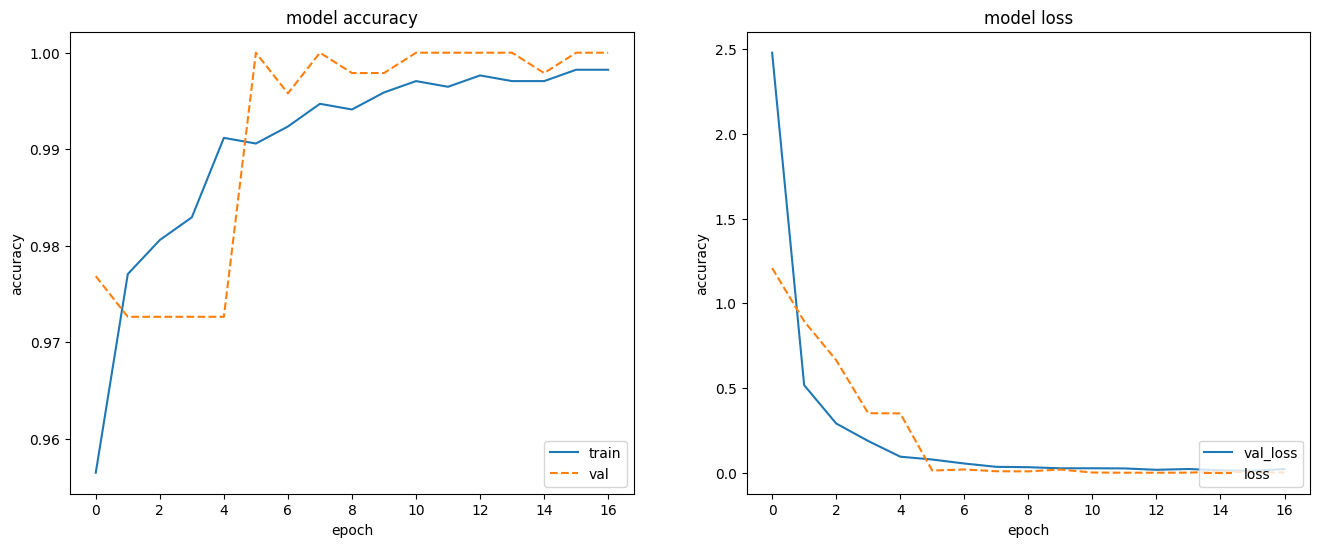

In [128]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history_cnn.history['accuracy'])
axes[0].plot(history_cnn.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history_cnn.history['loss'])
axes[1].plot(history_cnn.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

In [129]:
df_epc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/epc.csv', engine='python')
df_epc.shape

(804691, 38)

In [130]:
df_epc.drop(['id', 'reference','epc','score', 'count', 'maxRssiValue',
        'minRssiValue', 'maxTimeStamp', 'minTimeStamp', 'rssiDiff',
        'seenDiff', 'antenna1', 'antenna2', 'antenna3', 'antenna4', 'ts_percent0',
       'ts_percent1', 'ts_percent2', 'ts_percent3', 'ts_percent4',
       'ts_percent5', 'ts_percent6', 'ts_percent7', 'ts_percent8',
       'rv_percent0', 'rv_percent1', 'rv_percent2', 'rv_percent3',
       'rv_percent4', 'rv_percent5', 'rv_percent6', 'rv_percent7',
       'rv_percent8', 'lastModification'], axis=1, inplace=True)
df.shape

(1173, 4)

In [131]:
df_epc = df_epc.dropna(subset=['desired'])

In [132]:
df_epc["desired"] = df_epc["desired"].astype(int)

<ipython-input-132-0a63cd044442>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epc["desired"] = df_epc["desired"].astype(int)


In [133]:
X = []
Y = []
for index, row in df_epc.iterrows():
  X_ts = np.pad(np.array(json.loads(row['timeStamp'])), (175 - len(np.array(json.loads(row['timeStamp']))), 0), mode='constant')
  X_rv = np.pad(np.array(json.loads(row['rssiValue'])), (175 - len(np.array(json.loads(row['rssiValue']))), 0), mode='constant')
  X_an = np.pad(np.array(json.loads(row['antennas'])), (175 - len(np.array(json.loads(row['antennas']))), 0), mode='constant')
  Y_item = row['desired']
  X_item = np.array(list(zip(X_ts,X_rv,X_an)))
  X.append(X_item)
  Y.append(Y_item)

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(762553, 175, 3)
(762553,)


In [167]:
y = np.array(to_categorical(Y))

In [136]:
lossvalue, metrics = model.evaluate(X, y, verbose=1)

23830/23830 [==============================] - 47s 2ms/step - loss: 3.5642 - accuracy: 0.5120


In [147]:
predict_x =model.predict(X)
classes_x = np.argmax(predict_x,axis=1)


23830/23830 [==============================] - 33s 1ms/step


In [163]:
from sklearn.metrics import confusion_matrix
confusionmatrix = confusion_matrix(classes_x, Y)

In [164]:
print(confusionmatrix)

[[  4364 371796]
 [   367 386026]]


In [169]:
es1 = EarlyStopping(monitor='loss', mode='min',patience=5)

In [ ]:
history_cnn = model.fit(X, y, epochs=300, batch_size=30 ,shuffle=False , callbacks=[es1])

Epoch 1/300
16295/25419 [==================>...........] - ETA: 29s - loss: 0.0988 - accuracy: 0.9944